### Pix2Pix modeling

Model repo: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Paper: https://arxiv.org/pdf/1611.07004.pdf

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float, img_as_ubyte, io, color
from skimage.measure import compare_ssim
from skimage.measure import compare_mse
from cellvision_lib import train_test_val
# %pylab inline

In [60]:
import os
import glob
import random

def get_model_data_splits(imgs_dir, channel=1, train_pp=.6, test_pp=.2, val_pp=.2, seed=1):
    """
    Function which returns the a list containing a tuple of the channel image and its
    matched reference channel for training, validation, and test.
    
    Expects filenames of the format: sample#_channel#_z#.jpg
    
    returns train, val, test
    """
    REF_CHANNEL = 6
    random.seed(seed)
    #check to make sure percentages equal 1
    if train_pp+test_pp+val_pp != 1:
        raise Exception("train, test, val percentages must equal 1")
    
    #check to make sure channels in 1-5
    if channel > 5:
        raise Exception("channels can only be in range 1-5")
    
    img_paths = sorted(glob.glob(imgs_dir + '/*_channel{}_z*'.format(channel)))
    ref_paths = sorted(glob.glob(imgs_dir + '/*_channel{}_z*'.format(REF_CHANNEL)))
    random.shuffle(img_paths)
    sample_prefixes = {}
    for img_path in img_paths:
        fname = os.path.basename(img_path)
        end_sample_prefix_index = fname.find('_channel{}_z'.format(channel)) 
        start_z_index = end_sample_prefix_index + 11
        end_index = fname.find('.tif') 
        sample_prefix = fname[0:end_sample_prefix_index]
        z_depth = fname[start_z_index:end_index]
        ref_path = '{}/{}_channel{}_z{}.tif'.format(imgs_dir, sample_prefix, REF_CHANNEL, z_depth)
        if ref_path not in ref_paths:
            print("WARNING! Missing ref for " + ref_path)
            continue
        if sample_prefix not in sample_prefixes:
            sample_prefixes[sample_prefix] = [ (img_path, ref_path) ]
        else:
            sample_prefixes[sample_prefix] = sample_prefixes[sample_prefix] + [(img_path, ref_path)]
    
    sample_prefixes_lst = sorted(sample_prefixes.keys())
    num_samples = len(sample_prefixes_lst)
    random.shuffle(sample_prefixes_lst)
    
    train_end_idx = round(num_samples*train_pp)
    val_end_idx = train_end_idx + round(num_samples*val_pp)
    
    train_samples = sample_prefixes_lst[0:train_end_idx]
    val_samples = sample_prefixes_lst[train_end_idx:val_end_idx]
    test_samples = sample_prefixes_lst[val_end_idx:]
    
    train = []
    for sample in train_samples:
        train = train + sample_prefixes[sample]
        
    val = []
    for sample in val_samples:
        val = val + sample_prefixes[sample]
        
    test = []
    for sample in test_samples:
        test = test + sample_prefixes[sample]
        
    return train, val, test
    
    



In [61]:
folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50'
train, val, test = get_model_data_splits(folder_path, 
                      channel = 1, 
                      train_pp = .67, 
                      test_pp = .165, 
                      val_pp = .165, 
                      seed = 1)

print(len(train))
print(len(val))
print(len(test))
print(train[0])

4485
925
1066
('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample43_channel1_z27.tif', '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/sample43_channel6_z27.tif')


In [7]:
# Proprocesing the data for pix2pix model
import os
import glob
from shutil import copyfile

MAX_DEPTH = 100
NUM_SAMPLES = 109

# folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized'
# train, test, val = train_test_val(folder_path, channels = 1, train_pp = .67, test_pp = .165, val_pp = .165, set_seed = 1)

# train[0:10]

def clear_test_files(pix2pix_path):
    outer_paths = ['A','B']
    inner_paths = ['test','train','val']
    for outer in outer_paths:
        for inner in inner_paths:
            files = glob.glob('{root}/{split}/{inner}/*'.format(root=pix2pix_path, split=outer, inner=inner))
            for f in files:
                os.remove(f)
                
def isolate_test_samples(train, val, test):
    num_test = len(test)
    train_new = []
    val_new = []
    test_name = []
    
    for low, ref in train:
        fname = os.path.basename(comp)
        end_sample_prefix_index = fname.find('_channel{}_z'.format(channel)) 
        start_z_index = end_sample_prefix_index + 11
        end_index = fname.find('.tif') 
        sample_prefix = fname[0:end_sample_prefix_index]
                
def setup_images_for_pix2pix(src_path, channel, num_images):
    print("Setting up {} images for channel {}".format(num_images, channel))
    pix_folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel{}_{}'.format(channel,num_images)
    print("At path " + pix_folder_path)
    clear_test_files(pix_folder_path)
    train, test, val = train_test_val(src_path, 
                                      channels = channel, 
                                      train_pp = .67, 
                                      test_pp = .165, 
                                      val_pp = .165, 
                                      set_seed = 1)

    train_images = train[0:num_images]
    test_images = test[0:num_images]
    val_images = val[0:num_images]
    
    def get_pix_fname(base_dir, ref_fname, _channel, mode):
        fname = os.path.basename(comp)
        end_sample_prefix_index = fname.find('_channel{}_z'.format(channel)) 
        start_z_index = end_sample_prefix_index + 11
        end_index = fname.find('.tif') 
        sample_prefix = fname[0:end_sample_prefix_index]
        z_depth = fname[start_z_index:end_index]
        new_comp_path = '{}/A/{}/{}_channel{}_z{}.jpg'.format(base_dir, mode, sample_prefix, _channel, z_depth)
        new_ref_path = '{}/B/{}/{}_channel{}_z{}.jpg'.format(base_dir, mode, sample_prefix, _channel, z_depth)
        if not os.path.exists('{}/A/{}'.format(base_dir,mode)):
            os.makedirs('{}/A/{}'.format(base_dir,mode))
        if not os.path.exists('{}/B/{}'.format(base_dir,mode)):
            os.makedirs('{}/B/{}'.format(base_dir,mode))
        return new_comp_path, new_ref_path
    
    for i, (comp, ref) in enumerate(train_images):
        new_comp_path, new_ref_path = get_pix_fname(pix_folder_path, ref, channel, "train")
        copyfile(comp, new_comp_path)
        copyfile(ref, new_ref_path)
        
    print("done with training images")
    
    for i, (comp, ref) in enumerate(test_images):
        new_comp_path, new_ref_path = get_pix_fname(pix_folder_path, ref, channel, "test")
        copyfile(comp, new_comp_path)
        copyfile(ref, new_ref_path)
        
    print("done with testing images")
        
    for i, (comp, ref) in enumerate(val_images):
        new_comp_path, new_ref_path = get_pix_fname(pix_folder_path, ref, channel, "val")
        copyfile(comp, new_comp_path)
        copyfile(ref, new_ref_path)
        
    print("done with validation images")


folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50'
# folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-normalized'

setup_images_for_pix2pix(folder_path, 1, 1000)
setup_images_for_pix2pix(folder_path, 2, 1000)
setup_images_for_pix2pix(folder_path, 3, 1000)
setup_images_for_pix2pix(folder_path, 4, 1000)
setup_images_for_pix2pix(folder_path, 5, 1000)

# print()
# print(glob.glob('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1/A/train/*'))
# print()
# print(glob.glob('/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1/B/train/*'))


Setting up 1000 images for channel 1
At path /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000
done with training images
done with testing images
done with validation images
Setting up 1000 images for channel 2
At path /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000
done with training images
done with testing images
done with validation images
Setting up 1000 images for channel 3
At path /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_1000
done with training images
done with testing images
done with validation images
Setting up 1000 images for channel 4
At path /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_1000
done with training images
done with testing images
done with validation images
Setting up 1000 images for channel 5
At path /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_1000
done with training images
done with testing images
done with validation images


In [ ]:
"""
Commands to run with the pix2pix framework

python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/testing/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/testing/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/testing --num_imgs 200

python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000 --num_imgs 1000
bsub -o fold_1_1000.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000 --num_imgs 1000
bsub -o fold_1_1000.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_1000 --num_imgs 1000
bsub -o fold_1_1000.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_1000 --num_imgs 1000
bsub -o fold_1_1000.txt python datasets/combine_A_and_B.py --fold_A /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_1000/A --fold_B /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_1000/B --fold_AB /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_1000 --num_imgs 1000


bsub -Is -gpu "num=1:mode=exclusive_process:mps=yes" python train.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1 --name cellvision_channel1_100 --model pix2pix --direction AtoB --gpu 0 --display_id 0

bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o jobout.tx python train.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2 --name cellvision_channel2_100 --model pix2pix --direction AtoB --gpu 0 --display_id 0

bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o channel1_1000_jobout.txt python train.py --save_epoch_freq 25 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000 --name cellvision_channel1_1000 --model pix2pix --direction AtoB --gpu 0 --display_id 0
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o channel2_1000_jobout.txt python train.py --save_epoch_freq 25 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000 --name cellvision_channel2_1000 --model pix2pix --direction AtoB --gpu 0 --display_id 0
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o channel3_1000_jobout.txt python train.py --save_epoch_freq 25 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_1000 --name cellvision_channel3_1000 --model pix2pix --direction AtoB --gpu 0 --display_id 0
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o channel4_1000_jobout.txt python train.py --save_epoch_freq 25 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_1000 --name cellvision_channel4_1000 --model pix2pix --direction AtoB --gpu 0 --display_id 0
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o channel5_1000_jobout.txt python train.py --save_epoch_freq 25 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_1000 --name cellvision_channel5_1000 --model pix2pix --direction AtoB --gpu 0 --display_id 0

bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o channeltesting_jobout.txt python train.py --save_epoch_freq 25 --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000 --name cellvision_testing --model pix2pix --direction AtoB --gpu 0 --display_id 0


export CHANNEL=4
bsub -gpu "num=1:mode=exclusive_process:mps=yes" -o "$CHANNEL_jobout.txt" python train.py --dataroot "/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel$CHANNEL" --name "cellvision_$CHANNEL_100" --model pix2pix --direction AtoB --gpu 0 --display_id 0

bsub -Is -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000 --name cellvision_channel1_1000 --model pix2pix --direction AtoB --num_test 100
bsub -Is -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel2_1000 --name cellvision_channel2_1000 --model pix2pix --direction AtoB --num_test 100
bsub -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel3_1000 --name cellvision_channel3_1000 --model pix2pix --direction AtoB --num_test 100
bsub -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel4_1000 --name cellvision_channel4_1000 --model pix2pix --direction AtoB --num_test 100
bsub -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel5_1000 --name cellvision_channel5_1000 --model pix2pix --direction AtoB --num_test 100


bsub -Is -gpu "num=1:mode=exclusive_process:mps=yes" python test.py --dataroot /gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1 --name cellvision5 --model pix2pix --direction AtoB

"""

In [36]:
import glob
import os

channels = list(range(1,6))
sample_sizes =[100, 1000]

result_path = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results'

results_dirs = []
mses = []
ssims = []
for sample_size in sample_sizes:
    sub_results = []
    mses_sub = []
    ssim_sub = []
    for channel in channels:
        print("Getting MSE and SSIM for sample size {} and channel {}".format(sample_size, channel))
        result_dir = '{}/cellvision_channel{}_{}/test_latest/images'.format(result_path, channel, sample_size)
        real_path_low = '{}/*_real_A.png'.format(result_dir)
        real_low_imgs = glob.glob(real_path_low)
        print("getting {} images".format(len(real_low_imgs)))
        channel_mse = []
        channel_ssim = []
        for real_path_low in real_low_imgs:
            fname = os.path.basename(real_path_low)
            fname_prefix = fname[:-11]
            real_path_high = '{}/{}_real_B.png'.format(result_dir, fname_prefix)
            fake_path = '{}/{}_fake_B.png'.format(result_dir, fname_prefix)
            try:
                real_img_high = color.rgb2gray(io.imread(real_path_high).astype(np.uint))
                real_img_low = color.rgb2gray(io.imread(real_path_low).astype(np.uint))
                fake_img = color.rgb2gray(io.imread(fake_path).astype(np.uint))
            except OSError:
                print("OSERROR skipping " + fake_path)
            
            _min = real_img_high.min()
            _max = real_img_high.max()

            low_high_ssim = compare_ssim(real_img_low, real_img_high, data_range=_max-_min)
            fake_high_ssim = compare_ssim(fake_img, real_img_high, data_range=_max-_min)
            channel_ssim.append( (low_high_ssim,fake_high_ssim) )

            low_high_mse = compare_mse(real_img_low, real_img_high)
            fake_high_mse = compare_mse(fake_img, real_img_high)
            channel_mse.append( (low_high_mse,fake_high_mse) )
        
        mses_sub.append(channel_mse)
        ssim_sub.append(channel_ssim)
    mses.append(mses_sub)
    ssims.append(ssim_sub)

print(len(mses[0][0][0]))
# results_dir = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision5/test_latest/images'

# out_imgs = glob.glob(results_dir)


Getting MSE and SSIM for sample size 100 and channel 1
getting 100 images
Getting MSE and SSIM for sample size 100 and channel 2
getting 100 images
Getting MSE and SSIM for sample size 100 and channel 3
getting 100 images
Getting MSE and SSIM for sample size 100 and channel 4
getting 100 images
Getting MSE and SSIM for sample size 100 and channel 5
getting 100 images
Getting MSE and SSIM for sample size 1000 and channel 1
getting 100 images
Getting MSE and SSIM for sample size 1000 and channel 2
getting 42 images
OSERROR skipping /home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel2_1000/test_latest/images/sample106_channel2_z69_fake_B.png
Getting MSE and SSIM for sample size 1000 and channel 3
getting 100 images
Getting MSE and SSIM for sample size 1000 and channel 4
getting 100 images
Getting MSE and SSIM for sample size 1000 and channel 5
getting 100 images
2


In [37]:
print(len(ssims))
print(len(ssims[0]))
print(len(ssims[0][0]))
ssims[0][0]

2
5
100


[(0.038443256418102936, 0.5710460726728419),
 (0.0010819777901113423, 0.4047399222507796),
 (0.018457729000481878, 0.3270238864137745),
 (0.0333005285554644, 0.7490463404260681),
 (0.011421191496902008, 0.4965988910172831),
 (0.018095968033098965, 0.4090134265472663),
 (0.005904488520004072, 0.3578914560566957),
 (0.0015126814463474049, 0.49618061929452845),
 (0.0051625700297631555, 0.6167169180638488),
 (0.04491253893436096, 0.5859982120856874),
 (0.04053149839153547, 0.7395707676398158),
 (0.0013961180617240243, 0.466898899957563),
 (0.00513420494417428, 0.5749493065259476),
 (0.014446349933033849, 0.666824493598757),
 (0.027822218173668724, 0.8542591531512705),
 (0.06549571888198394, 0.8047822054315947),
 (0.04965651321542746, 0.8768692707544263),
 (0.029441121941345773, 0.7608125963445732),
 (0.029130833613065274, 0.7888791064281037),
 (0.009784763687432238, 0.5361171246542505),
 (0.040615291648297414, 0.7885471987102441),
 (0.026999018365195956, 0.6614348231027792),
 (0.0019290832

In [38]:
import statistics

low_means = []
fake_means = []
for sample_size in ssims:
    for channel in sample_size:
        low = [ssim[0] for ssim in channel]
        print(len(low))
        low_std = statistics.stdev(low)
        low_mean = statistics.mean(low)
        print(low_mean)
        low_means.append(low_mean)

        fake = [ssim[1] for ssim in channel]
        fake_std = statistics.stdev(fake)
        fake_mean = statistics.mean(fake)
        fake_means.append(fake_mean)


print("Low ssim mean {} with std {}".format(low_mean,low_std))
print("Fake ssim mean {} with std {}".format(fake_mean,fake_std))

# low_mse = [mse[0] for mse in mses]
# low_std_mse = statistics.stdev(low_mse)
# low_mean_mse = statistics.mean(low_mse)

# fake_mse = [mse[1] for mse in mses]
# fake_std_mse = statistics.stdev(fake_mse)
# fake_mean_mse = statistics.mean(fake_mse)
# print()
# print("Low mse mean {} with std {}".format(low_mean_mse,low_std_mse))
# print("Fake mse mean {} with std {}".format(fake_mean_mse,fake_std_mse))


100
0.028529030478586993
100
0.039695697152984016
100
0.414132028421265
100
0.6497733006490141
100
0.696460345984086
100
0.03996504922537468
42
0.05883045582823903
100
0.4007596800746858
100
0.6557800271816786
100
0.7122629199702946
Low ssim mean 0.7122629199702946 with std 0.17514559893611975
Fake ssim mean 0.6499470198406337 with std 0.17805093780597492


In [39]:
low_means

[0.028529030478586993,
 0.039695697152984016,
 0.414132028421265,
 0.6497733006490141,
 0.696460345984086,
 0.03996504922537468,
 0.05883045582823903,
 0.4007596800746858,
 0.6557800271816786,
 0.7122629199702946]

In [43]:
fake_means

[0.5901428507588693,
 0.5893046928831404,
 0.6414396322021859,
 0.6757501815108697,
 0.6748312903638221,
 0.5186856032990091,
 0.5517572684751489,
 0.5647310287281392,
 0.6134825046525527,
 0.6499470198406337]

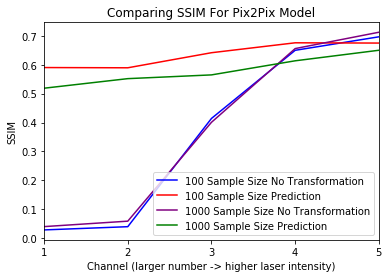

In [47]:
# Comparing MSE for denoising
plt.plot(list(range(1, 6)), low_means[0:5], label="100 Sample Size No Transformation", color='blue') 
plt.plot(list(range(1, 6)), fake_means[0:5], label="100 Sample Size Prediction", color='red') 
plt.plot(list(range(1, 6)), low_means[5:10], label="1000 Sample Size No Transformation", color='purple') 
plt.plot(list(range(1, 6)), fake_means[5:10], label="1000 Sample Size Prediction", color='green') 

plt.title('Comparing SSIM For Pix2Pix Model')
plt.legend(loc = 'lower right')
# plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('SSIM')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

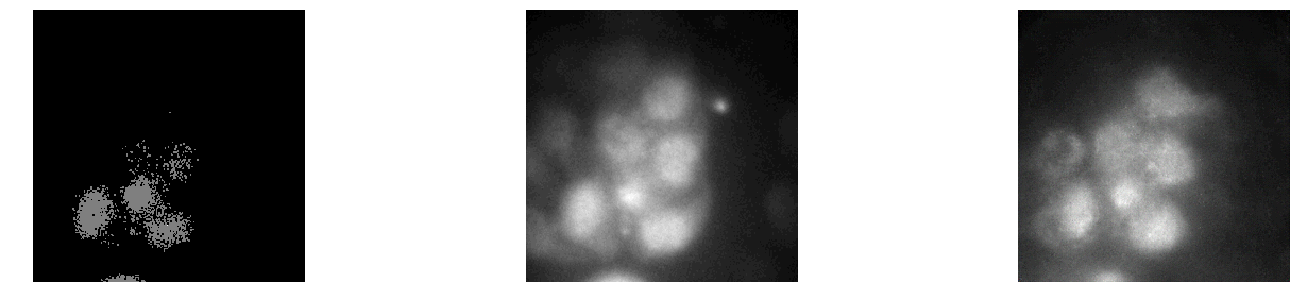

In [37]:
# Showing images
from skimage import exposure
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_real_A.png'
imsk_A = io.imread(path_to_data)
imsk_A = exposure.rescale_intensity(imsk_A,in_range=(0,np.max(imsk_A)))
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_real_B.png'
imsk_B = io.imread(path_to_data)
imsk_B = exposure.rescale_intensity(imsk_B,in_range=(0,np.max(imsk_B)))
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_fake_B.png'
fake = io.imread(path_to_data)
fake = exposure.rescale_intensity(fake,in_range=(0,np.max(fake)))
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(imsk_A);
ax[0].axis('off')
ax[1].imshow(imsk_B);
ax[1].axis('off')
ax[2].imshow(fake);
ax[2].axis('off')
plt.show()

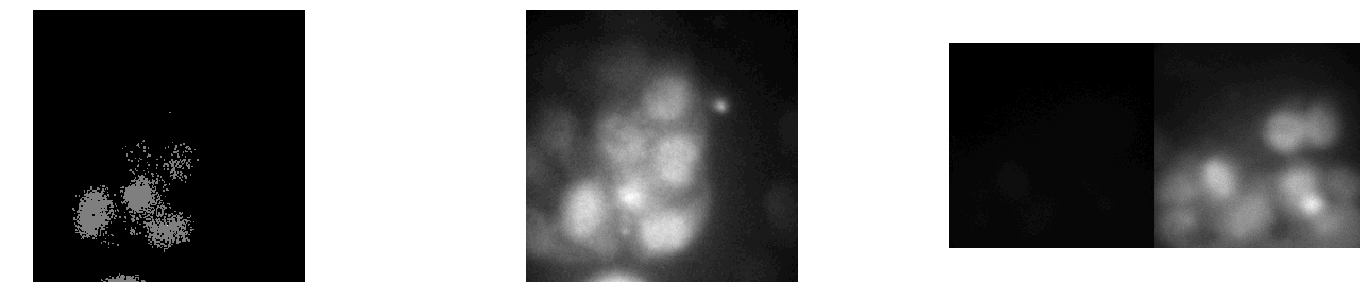

In [38]:
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_real_A.png'
imsk_A = io.imread(path_to_data)
imsk_A = exposure.rescale_intensity(imsk_A,in_range=(0,np.max(imsk_A)))
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample112_channel1_z34_real_B.png'
imsk_B = io.imread(path_to_data)
imsk_B = exposure.rescale_intensity(imsk_B,in_range=(0,np.max(imsk_B)))
path_to_data = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-pix2pix/channel1_1000/test/sample61_channel1_z48.jpg'
fake = io.imread(path_to_data)
fake = exposure.rescale_intensity(fake,in_range=(0,np.max(fake)))
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(25,5))
# ax[0].imshow(imsk_nl[0]);
ax[0].imshow(imsk_A);
ax[0].axis('off')
ax[1].imshow(imsk_B);
ax[1].axis('off')
ax[2].imshow(fake);
ax[2].axis('off')
plt.show()

In [39]:
path_to_data = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample27_channel1_z26_real_A.png'
path_to_data_B = '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample27_channel1_z26_real_B.png'

imsk_A = io.imread(path_to_data)
imsk_B = io.imread(path_to_data_B)
_min = imsk_A.min()
_max = imsk_A.max()

low_high_ssim = compare_ssim(imsk_A, real_img_high, data_range=_max-_min)
low_high_ssim

FileNotFoundError: [Errno 2] No such file or directory: '/home/dg3047/capstone/pytorch-CycleGAN-and-pix2pix/results/cellvision_channel1_1000/test_latest/images/sample27_channel1_z26_real_A.png'